In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def rolling_backfill(col):
    colist = []
    col_main = col.copy()
    last_nonnan = np.nan
    MEANY = col.rolling(10).mean()
    for i in range(len(col)):
        
        if MEANY.iloc[i]>-1:
            last_nonnan = MEANY.iloc[i]
        if ~(col.iloc[i]>-1) & i>1:
            colist.append(last_nonnan)
        else:
            colist.append(col.iloc[i])
        if colist[i]>-1:
            continue
        else:
            colist[i] = last_nonnan
            
    return colist

In [4]:
X_train = pd.read_csv('../sibur/train_features.csv',index_col='timestamp',parse_dates = ['timestamp'])
Y_train = pd.read_csv('../sibur/train_targets.csv',index_col='timestamp',parse_dates = ['timestamp'])
sub = pd.read_csv('../sibur/sample_submission.csv', index_col='timestamp',parse_dates = ['timestamp'])
X_test = pd.read_csv('../sibur/test_features.csv',index_col='timestamp',parse_dates = ['timestamp'])
data_full = pd.concat([X_train,X_test])
data_full['A_rate'][data_full['A_rate']<20] = np.nan

data_full['A_C2H6'][data_full['A_C2H6']<2] = np.nan
data_full['A_C2H6'][data_full['A_C2H6']>7] = np.nan

data_full['A_C3H8'][data_full['A_C3H8']<33] = np.nan
data_full['A_C3H8'][data_full['A_C3H8']>42] = np.nan
data_full['A_iC4H10'][data_full['A_iC4H10']<15] = np.nan

data_full['A_iC4H10'][data_full['A_iC4H10']>20] = np.nan
data_full['A_nC4H10'][data_full['A_nC4H10']>28] = np.nan

data_full['A_nC4H10'][data_full['A_nC4H10']<22.5] = np.nan
data_full['A_C6H14'][data_full['A_C6H14']>10] =np.nan
data_full[data_full['A_nC5H12']>6]=np.nan

data_full['A_C2H6_volb'] = data_full['A_C2H6']*data_full['A_rate']/data_full['B_rate']
data_full['A_C3H8_volb'] = data_full['A_C3H8']*data_full['A_rate']/data_full['B_rate']
data_full['A_C2H6_volume'] = data_full['A_C2H6']*data_full['A_rate']
data_full['A_C3H8_volume']= data_full['A_C3H8']*data_full['A_rate']
for col in data_full.columns:
    for i in [5,10,20,50,100]:
        data_full[f'{col}_rmean{i}'] = data_full[col].rolling(i).mean()



for col in data_full.columns:
    for i in [10,150]+list(range(170,220)):
        data_full[f'{col}_sh{i}'] = data_full[col].shift(i)


    
X_train = data_full.head(len(X_train))
X_test = data_full.tail(len(X_test))
X_train = X_train[200:]
Y_train = Y_train[200:]

In [5]:
def run_cv(features,labels, model ,test,important_cols=[]):
    folds = KFold(n_splits=5 ,shuffle=False)
    scores = []
    oofs = []
    for i, (train_idx, val_idx) in enumerate(folds.split(features)):
        train_prt,val_prt = features.iloc[train_idx].copy(),features.iloc[val_idx].copy()
        Target_trn, Target_trn_val = labels.iloc[train_idx].copy(), labels.iloc[val_idx].copy()
        for col in important_cols:
            Target_trn = Target_trn[-train_prt[col].isna()]
            train_prt = train_prt[-train_prt[col].isna()]
            
        for col in train_prt.columns:
            train_prt[col],val_prt[col] = rolling_backfill(train_prt[col]),rolling_backfill(val_prt[col])

            train_prt[col],val_prt[col] = train_prt[col].fillna(train_prt[col].mean()),val_prt[col].fillna(train_prt[col].mean())
        modl = model
        modl.fit(train_prt,Target_trn)
        preds = modl.predict(val_prt)
        print(len(Target_trn_val))
        score = mean_absolute_percentage_error(Target_trn_val,preds)
        scores.append(score)
        oofs.append(preds)
        print(score)
    print(np.mean(scores))
    
    for col in important_cols:
            labels = labels[-features[col].isna()]
            features = features[-features[col].isna()]
    for col in features.columns:
            features[col],test[col] = rolling_backfill(features[col]),rolling_backfill(test[col])
            features[col],test[col] = features[col].fillna(features[col].mean()),test[col].fillna(features[col].mean())
    modl = model
    modl.fit(features,labels)
    return modl.predict(test),np.concatenate(oofs)

In [6]:
X_train.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate',
       ...
       'A_C3H8_volume_rmean100_sh210', 'A_C3H8_volume_rmean100_sh211',
       'A_C3H8_volume_rmean100_sh212', 'A_C3H8_volume_rmean100_sh213',
       'A_C3H8_volume_rmean100_sh214', 'A_C3H8_volume_rmean100_sh215',
       'A_C3H8_volume_rmean100_sh216', 'A_C3H8_volume_rmean100_sh217',
       'A_C3H8_volume_rmean100_sh218', 'A_C3H8_volume_rmean100_sh219'],
      dtype='object', length=4452)

In [7]:
FEATURES = ['A_C2H6_rmean5_sh200','A_C2H6_sh190','A_C2H6_sh209','A_C3H8_rmean5_sh200',
            'A_C6H14_sh190','A_C2H6_volb_sh185','A_C2H6_volume_rmean20_sh180','A_C3H8_volume_rmean50_sh180']
IMPRTFEATS=FEATURES
col= 'B_C2H6'
STEPEN = 1.

Train_clean = X_train[-Y_train[col].isna()].copy()[FEATURES]**STEPEN
labels_clean = Y_train[-Y_train[col].isna()].copy()

Train_clean = pd.concat([Train_clean.loc[:'2020-01-25 00:00:00'],Train_clean.loc['2020-02-15 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-01-25 00:00:00'],labels_clean.loc['2020-02-15 14:00:00':]])

Train_clean = pd.concat([Train_clean.loc[:'2020-04-07 15:00:00'],Train_clean.loc['2020-04-12 20:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-04-07 15:00:00'],labels_clean.loc['2020-04-12 20:00:00':]])




test_clean = X_test.copy()[FEATURES]**STEPEN
model =  LinearRegression()

sub[col],Train_clean['oof'] = run_cv(Train_clean,labels_clean[col], model ,test_clean,IMPRTFEATS)


854
3.217464141405023
854
5.246746658597765
854
5.1034746497713215
853
5.687163028483195
853
6.221013716633177
5.095172438978096


<AxesSubplot:xlabel='timestamp'>

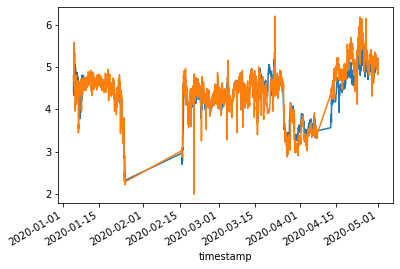

In [8]:
Train_clean['oof'].plot()
labels_clean[col].plot()

In [9]:
FEATURES = ['A_C3H8_sh200','A_C3H8_sh150','A_C3H8_sh209','A_C3H8_sh190',
           'A_C3H8_sh185',
            'A_C3H8_sh188',
            'A_C3H8_sh192',
            'A_C3H8_sh197',
            'A_C3H8_sh198',
            'A_C3H8_sh199',
           ]
IMPRTFEATS=FEATURES
col= 'B_C3H8'
STEPEN = 10

Train_clean = X_train[-Y_train[col].isna()].copy()[FEATURES]**STEPEN
labels_clean = Y_train[-Y_train[col].isna()].copy()

Train_clean = pd.concat([Train_clean.loc[:'2020-01-25 00:00:00'],Train_clean.loc['2020-02-12 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-01-25 00:00:00'],labels_clean.loc['2020-02-12 14:00:00':]])


Train_clean = pd.concat([Train_clean.loc[:'2020-04-08 15:00:00'],Train_clean.loc['2020-04-11 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-04-08 15:00:00'],labels_clean.loc['2020-04-11 14:00:00':]])



test_clean = X_test.copy()[FEATURES]**STEPEN
model =  LinearRegression()

sub[col],Train_clean['oof'] = run_cv(Train_clean,labels_clean[col], model ,test_clean,IMPRTFEATS)


904
2.48311964806752
903
2.6959134294191904
903
1.9441260736130597
903
2.2568243772175056
903
1.5614352606213944
2.188283757787734


<AxesSubplot:xlabel='timestamp'>

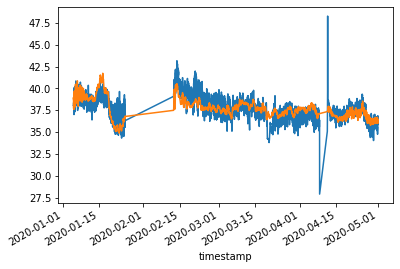

In [10]:
labels_clean[col].plot()
Train_clean['oof'].plot()

In [11]:
FEATURES = ['A_iC4H10_sh190','A_iC4H10_sh209','A_nC4H10_sh190']
IMPRTFEATS =['A_iC4H10_sh190']
col= 'B_iC4H10'
STEPEN = 1

Train_clean = X_train[-Y_train[col].isna()].copy()[FEATURES]**STEPEN
labels_clean = Y_train[-Y_train[col].isna()].copy()

Train_clean = pd.concat([Train_clean.loc[:'2020-01-25 00:00:00'],Train_clean.loc['2020-02-15 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-01-25 00:00:00'],labels_clean.loc['2020-02-15 14:00:00':]])

Train_clean = pd.concat([Train_clean.loc[:'2020-04-08 15:00:00'],Train_clean.loc['2020-04-11 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-04-08 15:00:00'],labels_clean.loc['2020-04-11 14:00:00':]])



test_clean = X_test.copy()[FEATURES]**STEPEN
model =  LinearRegression()

sub[col],Train_clean['oof'] = run_cv(Train_clean,labels_clean[col], model ,test_clean,IMPRTFEATS)


875
0.9104264390249704
875
1.1310102084054692
874
1.5267479527377772
874
1.790604500328305
874
1.653026313738994
1.4023630828471032


<ipython-input-5-a69649283c94>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col],test[col] = rolling_backfill(features[col]),rolling_backfill(test[col])
<ipython-input-5-a69649283c94>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col],test[col] = features[col].fillna(features[col].mean()),test[col].fillna(features[col].mean())


<AxesSubplot:xlabel='timestamp'>

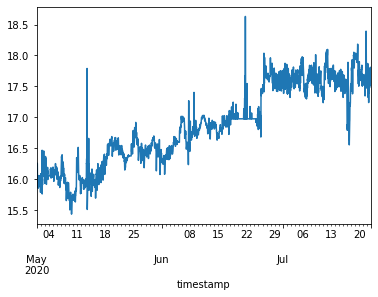

In [12]:
sub[col].plot()

In [13]:
FEATURES =[
 'A_nC4H10_sh150',
 'A_nC4H10_sh190',
 'A_nC4H10_sh200',
 'A_nC4H10_sh209',

    'A_nC4H10_sh185',
    'A_nC4H10_sh186',
    'A_nC4H10_sh187',
    'A_nC4H10_sh188',
    'A_nC4H10_sh189',
    'A_nC4H10_sh191',
    'A_nC4H10_sh192',
    'A_nC4H10_sh193',
    'A_nC4H10_sh194',
    'A_nC4H10_sh195',
    'A_nC4H10_sh196',
    'A_nC4H10_sh197',
    'A_nC4H10_sh198',
    'A_nC4H10_sh199',
    'A_nC4H10_sh201',
    'A_nC4H10_sh202',
    'A_nC4H10_sh203',
    'A_nC4H10_sh205',
    'A_nC4H10_sh206',
    'A_nC4H10_sh208',
    'A_nC4H10_sh210',
    'A_nC4H10_sh211',
]
IMPRTFEATS = []
col= 'B_nC4H10'

Train_clean = X_train[-Y_train[col].isna()].copy()[FEATURES]
labels_clean = Y_train[-Y_train[col].isna()].copy()

Train_clean = pd.concat([Train_clean.loc[:'2020-01-25 00:00:00'],Train_clean.loc['2020-02-15 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-01-25 00:00:00'],labels_clean.loc['2020-02-15 14:00:00':]])

Train_clean = pd.concat([Train_clean.loc[:'2020-04-07 15:00:00'],Train_clean.loc['2020-04-12 14:00:00':]])
labels_clean = pd.concat([labels_clean.loc[:'2020-04-07 15:00:00'],labels_clean.loc['2020-04-12 14:00:00':]])



test_clean = X_test.copy()[FEATURES]


    
model =  LinearRegression()

sub[col],Train_clean['oof'] = run_cv(Train_clean,labels_clean[col], model ,test_clean,IMPRTFEATS)

856
1.1626113189676024
856
1.2371846916217983
856
1.1301843867109997
856
1.1545713923079572
856
1.0536431096687635
1.1476389798554245


<AxesSubplot:xlabel='timestamp'>

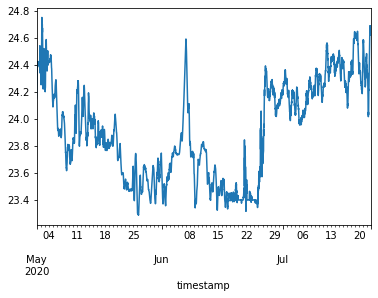

In [14]:
sub[col].plot()

In [17]:
sub.head()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
timestamp,,,,
2020-05-01 00:00:00,5.003357,36.539911,15.920865,24.157539
2020-05-01 00:30:00,5.017491,36.187741,16.024572,24.169416
2020-05-01 01:00:00,5.026245,36.459446,16.006109,24.205939
2020-05-01 01:30:00,4.983544,36.370566,15.982808,24.243281
2020-05-01 02:00:00,4.930023,36.299467,16.078807,24.293380


In [16]:
sub.to_csv('subshitv2.csv')

<AxesSubplot:xlabel='timestamp'>

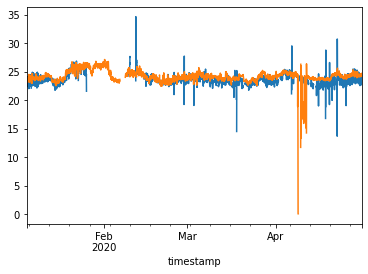